# Inspect the properties of the various covariance models

 - Time to reach 0.5 of the decorellation (Ponte and Klein)
 - Calculate the band-width parameter of the gamma-exp-cosine function
 - Calculate the spectral slope of the gamma-exp function (use jax)

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy.interpolate import interp1d
from scipy import signal
import speccy
import nonstat_itides as nsit


In [3]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'

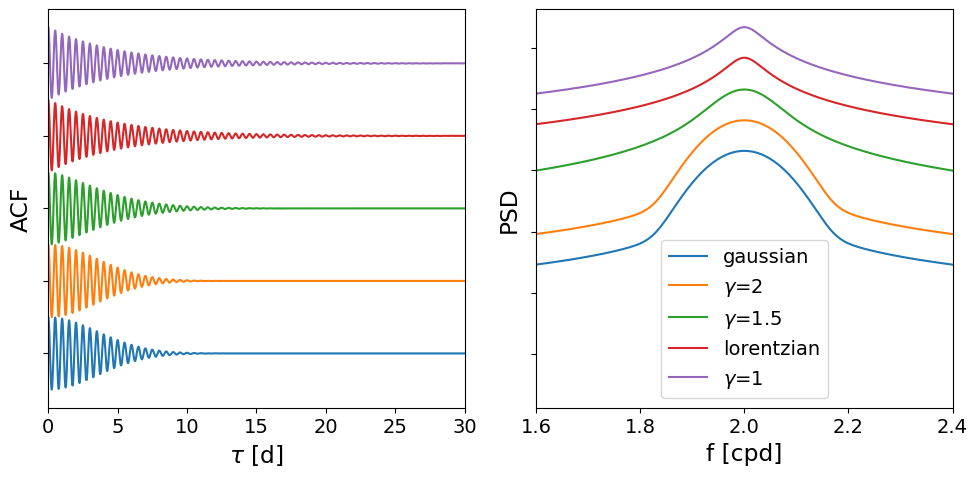

In [5]:
dtout = 1/192.
t = np.arange(0,200,dtout)

# Plot some acf/psd
plt.figure(figsize=(10,5))
ax1=plt.subplot(121)
ax2=plt.subplot(122)
ax1.set_xlim(0,30)
ax2.set_xlim(1.6,2.4)


scale=1
offset=np.log10(scale)*2
acf1 = nsit.itmodel_expquad(t, t[0], (1, 1/np.sqrt(2)*5.)) # Needs scaling
f_S1, S1 = speccy.bochner(acf1, delta=dtout)
p1a, = ax1.plot(t-t[0],acf1+offset)
p1b, = ax2.semilogy(f_S1, S1*scale)

scale*=10
offset=np.log10(scale)*2
# acf1 = itmodel_gamma(t, t[0], (1, 5., nsit.logit(2-1e-15, scale=2)))
acf1 = nsit.itmodel_gamma(t, t[0], (1, 5., 2))

f_S1, S1 = speccy.bochner(acf1, delta=dtout)
p2a, = ax1.plot(t-t[0],acf1+offset)
p2b, = ax2.semilogy(f_S1, S1*scale)

scale*=10
offset=np.log10(scale)*2
# acf1 = itmodel_gamma(t, t[0], (1, 5., nsit.logit(0.5, scale=2)))
acf1 = nsit.itmodel_gamma(t, t[0], (1, 5., 1.5))

f_S1, S1 = speccy.bochner(acf1, delta=dtout)
p3a, = ax1.plot(t-t[0],acf1+offset)
p3b, = ax2.semilogy(f_S1, S1*scale)

scale*=10
offset=np.log10(scale)*2
acf1 = nsit.itmodel_lorentzian(t, t[0], (1, 5.))
f_S1, S1 = speccy.bochner(acf1, delta=dtout)
p4a, = ax1.plot(t-t[0],acf1+offset)
p4b, = ax2.semilogy(f_S1, S1*scale)

scale*=10
offset=np.log10(scale)*2
# acf1 = itmodel_gamma(t, t[0], (1, 5., nsit.logit(1, scale=2)))
acf1 = nsit.itmodel_gamma(t, t[0], (1, 5., 1))

f_S1, S1 = speccy.bochner(acf1, delta=dtout)
p5a, = ax1.plot(t-t[0],acf1+offset)
p5b, = ax2.semilogy(f_S1, S1*scale)



labels = ('gaussian',r'$\gamma$=2',r'$\gamma$=1.5','lorentzian',r'$\gamma$=1')

ax1.set_yticks([0, 2,4,6,8])
# ax1.set_yticklabels(labels)
ax1.set_yticklabels([])

ax1.set_xlabel(r'$\tau$ [d]')
ax2.set_xlabel('f [cpd]')
ax1.set_ylabel('ACF')
ax2.set_ylabel('PSD')
ax2.set_yticklabels([])
ax2.legend( (p1a,p2b,p3b,p4b,p5b),labels,)
plt.tight_layout()
plt.savefig('../FIGURES/cov_model_acf_psd.png',dpi=150)

# Compare with the Zaron 2022 parameterisation

$$
S(\omega) = S_0 + \frac{A}{\pi}\frac{\lambda}{(\omega-\omega_0)^2 + \lambda^2}
$$

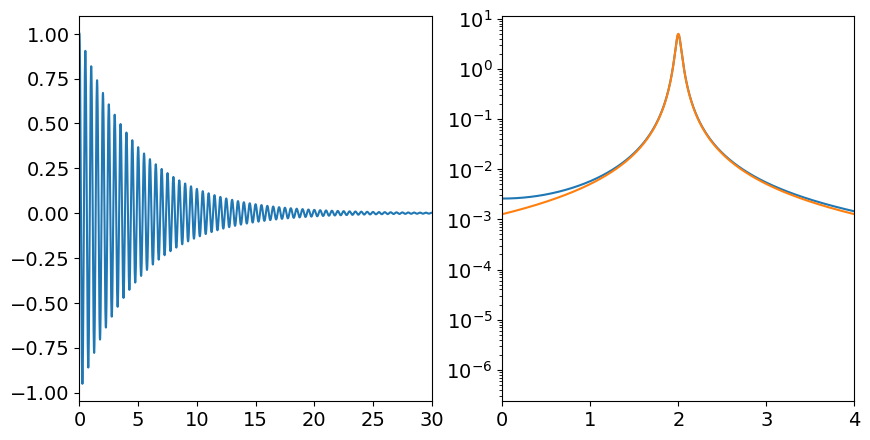

In [64]:
def lorentzian_z22(omega, S0, A, λ, omega0):
    return S0 + A/np.pi * λ / ((omega-omega0)**2. + λ**2.)

tau_d2 = 5.
A = 1.
Sz = lorentzian_z22(f_S1, 0, A/2, 1/(2*np.pi*tau_d2), 2)

plt.figure(figsize=(10,5))
ax1=plt.subplot(121)
ax2=plt.subplot(122)
ax1.set_xlim(0,30)
#ax2.set_xlim(1.6,2.4)
ax2.set_xlim(0,4)

scale=1
offset=np.log10(scale)*2
#acf1 = nsit.itmodel_expquad(t, t[0], (1, 1/np.sqrt(2)*5.)) # Needs scaling
acf1 = nsit.itmodel_gamma(t, t[0], (1, tau_d2, 1))

f_S1, S1 = speccy.bochner(acf1, delta=dtout)
p1a, = ax1.plot(t-t[0],acf1+offset)
p1b, = ax2.semilogy(f_S1, S1*scale)
p1c, = ax2.semilogy(f_S1, Sz*scale)

$\tau_{x} = - \gamma^{-1} \tau_\mathrm{d} \log x$

In [72]:
30/(2*np.pi)

4.7746482927568605

In [71]:
def tau_decorr(x, tau_d, gamma):
    return 1/gamma * tau_d * np.log(x)

tau_decorr(0.5, 1., 1.)

-0.6931471805599453

In [5]:
import nonstat_itides_jax as nsitj
from jaxopt import Bisection1

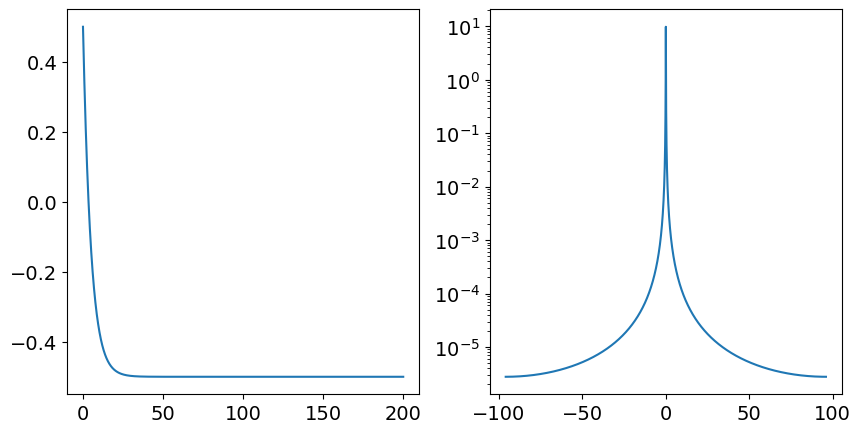

In [6]:
plt.figure(figsize=(10,5))
ax1=plt.subplot(121)
ax2=plt.subplot(122)
acf1 = nsitj.gamma_exp_1d(t, t[0], (1, 5., 1.)) # Needs scaling
f_S1, S1 = nsitj.bochner(acf1, delta=dtout)
p1a, = ax1.plot(t-t[0],acf1-0.5)
p1b, = ax2.semilogy(f_S1, S1)

In [7]:
# Root of the gamma exp function
def F_gexp(x, myparams):
    acf = nsitj.gamma_exp_1d(x, 0., myparams)
    return acf - 0.5

def root_gexp(params):
    bisec = Bisection(F_gexp, 0, 100 )
    return bisec.run(myparams=params).params

myparams=(1, 100., 2.0)
root_gexp(myparams)

Array(83.25500488, dtype=float64)

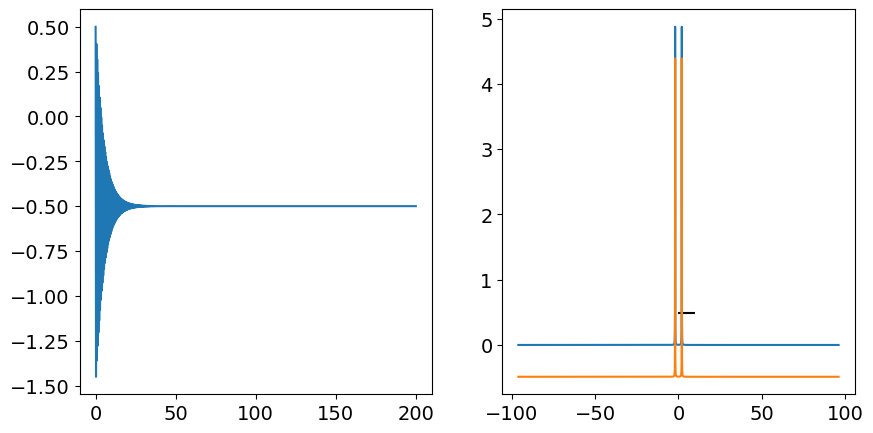

In [8]:
plt.figure(figsize=(10,5))
ax1=plt.subplot(121)
ax2=plt.subplot(122)
acf1 = nsitj.itmodel_gamma(t, t[0], (1, 5., 1.))
f_S1, S1 = nsitj.bochner(acf1, delta=dtout)
plt.hlines(0.1*S1.max(), 0, 10,'k')
p1a, = ax1.plot(t-t[0],acf1-0.5)
p1b, = ax2.plot(f_S1, S1)
p1b, = ax2.plot(f_S1, S1-0.1*S1.max())

In [11]:
# Calculate bandwidth

def F_itmodel(x, myparams, cutoff=0.1, f0=0.5):
    acf = nsitj.itmodel_gamma(x, 0., myparams, l=f0)
    f_S1, S1 = nsitj.bochner(acf, delta=dtout)
    return S1 - cutoff*S1.max(), f_S1

# def root_itmodel(x, params):
#     bisec = Bisection(F_itmodel, 0.1, 5 )
#     return bisec.run(x=x, myparams=myparams).params

def calc_bandwidth(x, params, f0=0.5, cutoff=0.1):
    """
    See Van Haren 2004 (and Fu 1981) for definition
    """
    a, f = F_itmodel(x, params, cutoff=cutoff, f0=f0)
    # Do it numerically
    zero_crossings = np.where(np.diff(np.sign(a)))
    f_roots = f[zero_crossings]
    f_low, f_high= f_roots[f_roots>0]
    fi = f0/(f_high-f_low)
    T = 2*np.pi/f0
    return T*fi, f_high, f_low

def calc_bandwidth_v2(x, params, f0=0.5, cutoff=0.1):
    """
    See Van Haren 2004 (and Fu 1981) for definition
    """
    a, f = F_itmodel(x, params, cutoff=cutoff, f0=f0)

    # Interpolate to get better resolution
    Fi = interp1d(f, a, kind=2)
    fi = np.linspace(1.1, 2.9,1000)
    ai = Fi(fi)
    # Do it numerically
    zero_crossings = np.where(np.diff(np.sign(ai)))
    f_roots = fi[zero_crossings]
    f_low, f_high= f_roots[f_roots>0]
    fi = f0/(f_high-f_low)
    T = 2*np.pi/f0
    return T*fi, f_high, f_low


print(calc_bandwidth(t, (1, 5., 2.0)))
print(calc_bandwidth_v2(t, (1, 5., 2.0)))


(Array(32.22146311, dtype=float64), Array(2.095, dtype=float64), Array(1.9, dtype=float64))
(32.288591161895056, 2.0963963963963965, 1.9018018018018017)


In [12]:
print(calc_bandwidth_v2(t, (0.07786797, 23.466465,1.0), cutoff=0.1, f0=0.5))
print(calc_bandwidth_v2(t, (0.0881786,  6.0941086,  1.7953527 ), cutoff=0.1, f0=0.5))

(134.12184021094896, 2.0225225225225225, 1.9756756756756757)
(38.74630939427414, 2.08018018018018, 1.918018018018018)


In [13]:
# from scipy.interpolate import interp1d

# a, f = F_itmodel(t, (1, 5., 2.0))
# F = interp1d(a, f)
# F(0.)

In [14]:
gammas = np.arange(1,2.25,0.25)
taus = np.arange(1,30., 1.)

m,n = gammas.shape[0], taus.shape[0]

data_decorr = np.zeros((m,n))
data_bandwidth = np.zeros((m,n))

for ii in range(m):
    for jj in range(n):
        data_bandwidth[ii,jj],_,_ = calc_bandwidth_v2(t, (1, taus[jj], gammas[ii]))
        data_decorr[ii,jj]= root_gexp((1, taus[jj], gammas[ii]))

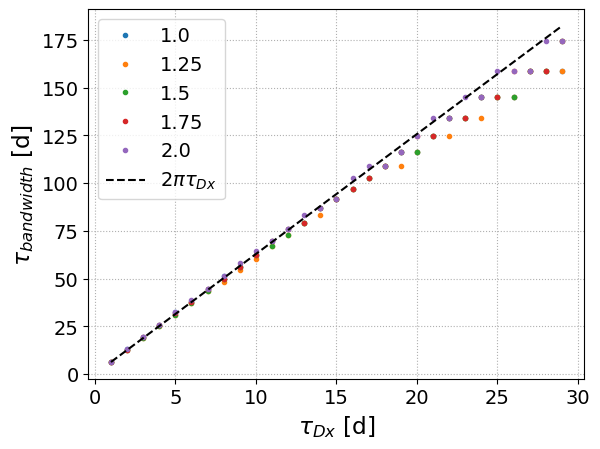

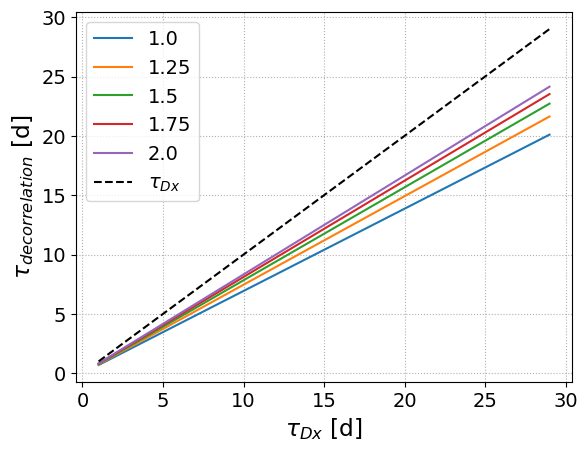

In [15]:
plt.figure()
for ii in range(m):
    plt.plot(taus, data_bandwidth[ii,:],'.')
plt.plot(taus, 2*np.pi*taus,'k--')
plt.grid(True, ls=':')
plt.ylabel(r'$\tau_{bandwidth}$ [d]')
plt.xlabel(r'$\tau_{Dx}$ [d]')
plt.legend(gammas.tolist()+[r'$2\pi\tau_{Dx}$',])
plt.savefig('../FIGURES/covariance_properties_tauband_v_taudx_v2.png',dpi=150)

plt.figure()
for ii in range(m):
    plt.plot(taus, data_decorr[ii,:],)

plt.plot(taus, taus,'k--')
plt.legend(gammas.tolist()+[r'$\tau_{Dx}$',])

plt.grid(True, ls=':')
plt.ylabel(r'$\tau_{decorrelation}$ [d]')
plt.xlabel(r'$\tau_{Dx}$ [d]')
plt.savefig('../FIGURES/covariance_properties_taudecorr_v_taudx.png',dpi=150)


Text(0.5, 0, '$\\tau_{Dx}$ [d]')

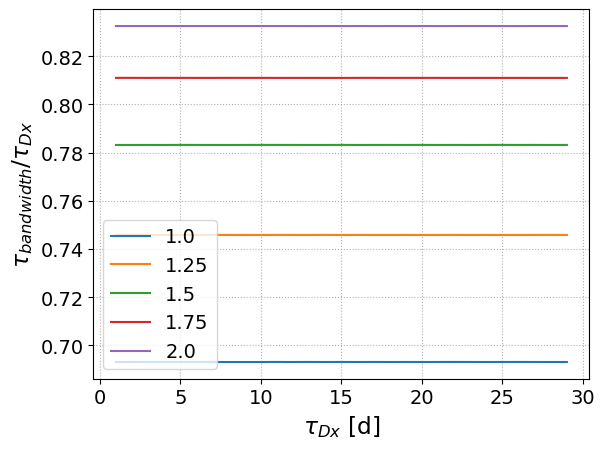

In [74]:
plt.figure()
for ii in range(m):
    plt.plot(taus, data_decorr[ii,:]/taus,)

# plt.plot(taus, taus,'k--')
plt.legend(gammas.tolist())

plt.grid(True, ls=':')
plt.ylabel(r'$\tau_{bandwidth}/\tau_{Dx}$')
plt.xlabel(r'$\tau_{Dx}$ [d]')

# Slope of the gamma-exp function



In [13]:
import jax

In [14]:
def F_gexp(x, myparams):
    
    acf = nsit.gamma_exp_1d(x, 0., myparams)
    f, S = nsit.bochner(acf, delta=dtout, bias=True)
    return f, S

def grad_gexp(x, myparams):
    f, S =  F_gexp(x, myparams)
    
    dS = np.gradient(np.log10(S), np.log10(f))
    
    return np.nanmin(dS)

# plt.figure()
# plt.loglog(f, S)

# plt.figure()
# plt.semilogx(f, dS)


In [15]:

gammas = np.arange(0.25,2.25,0.25)
taus = np.arange(1,30., 1.)

m,n = gammas.shape[0], taus.shape[0]

data_slope = np.zeros((m,n))

for ii in range(m):
    for jj in range(n):
        data_slope[ii,jj]= grad_gexp(t, (1, taus[jj], gammas[ii]))

/tmp/ipykernel_59454/2635195603.py:10: RuntimeWarning: divide by zero encountered in log10
  dS = np.gradient(np.log10(S), np.log10(f))
/tmp/ipykernel_59454/2635195603.py:10: RuntimeWarning: invalid value encountered in log10
  dS = np.gradient(np.log10(S), np.log10(f))
/home/jupyter-mrayson/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/jupyter-mrayson/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))


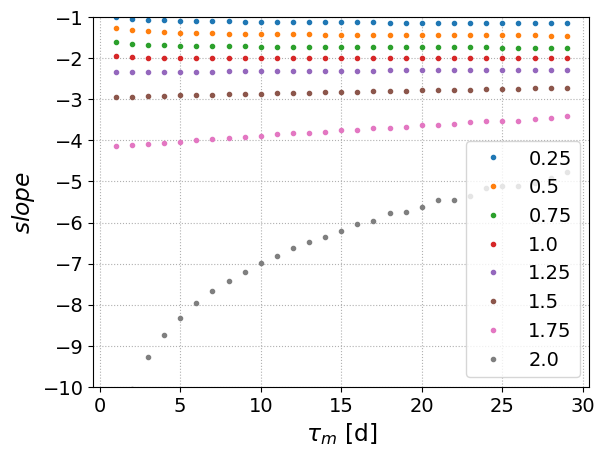

In [16]:
plt.figure()
for ii in range(m):
    plt.plot(taus, data_slope[ii,:],'.')

plt.legend(gammas.tolist()+[r'$\tau_{Dx}$',])

plt.grid(True, ls=':')
plt.ylabel(r'$slope$')
plt.xlabel(r'$\tau_{m}$ [d]')
plt.ylim(-10,-1)
plt.savefig('../FIGURES/covariance_properties_slope_v_taum.png',dpi=150)


In [17]:
# Put 3 plots together...

